# 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mdtraj as md
#import mcg
import h5py
import pandas as pd
import sys
sys.path.append('../')
import matplotlib_config as cfg
import fnmatch
from matplotlib import cm
import pickle
from matplotlib.colors import PowerNorm

from oldest_path_length import find_age_of_oldest_path

In [2]:
max_len = 100
max_force_eval = 1e10

In [3]:
step2us = 2e-9
burst = 1e5

In [4]:
AA = False

In [5]:
if AA == True:
    algorithm = 'AA'
else:
    algorithm = '1wS'

In [6]:
if AA == True:
    datafolders =['../AlwaysAcceptingClathrates/data_mu175_chain0_batch_0/', '../AlwaysAcceptingClathrates/data_mu175_chain0_batch_1/', '../AlwaysAcceptingClathrates/data_mu175_chain0_batch_2/', '../AlwaysAcceptingClathrates/data_mu175_chain0_batch_3/']
else:
    datafolders =['../ClathrateTPS/data_mu175_chain1_batch_1/', '../ClathrateTPS/data_mu175_chain1_batch_2/', '../ClathrateTPS/data_mu175_chain1_batch_3/', '../ClathrateTPS/data_mu175_chain1_batch_4/']

gro_folder = 'gro_files'

In [7]:
if AA == True:
    chains = [[datafolders[0], datafolders[1], datafolders[2], datafolders[3]]]
else:
    chains = [[datafolders[0], datafolders[1],  datafolders[2],  datafolders[3]]]

In [8]:
runs = 12

In [9]:
top_file = os.path.join(gro_folder, 'conf.gro')

In [10]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'trajectory_weights.npy'))[1:]
    
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    df['Weights'] = 0.0
    
    successful_indices = df[df['Successful'] == True].index
    
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [11]:
run_data = {}

for datafolder in datafolders:
    print(datafolder)
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {}

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue


../ClathrateTPS/data_mu175_chain1_batch_1/
../ClathrateTPS/data_mu175_chain1_batch_2/
../ClathrateTPS/data_mu175_chain1_batch_3/
../ClathrateTPS/data_mu175_chain1_batch_4/


In [12]:
with open("successful_shooting_frames.txt", "w") as f:
    for dataset in run_data:
        for run in run_data[dataset]:
            f.write(f'{dataset}, {run}\n')
            df = run_data[dataset][run]['log']
            df_successful = df[df['Successful'] == True]

            o = df_successful['SP frame on old traj'].values
            n = df_successful['SP frame on new traj'].values
            if AA == True:
                directions = np.where(df_successful['Final state'].values == 'A', -1, 1)
            else:
                directions = df_successful['Shooting Direction'].values

            for i in range(len(df_successful)):
                f.write(f"{o[i]}\t{n[i]}\t{directions[i]}\n")

## Calculate frames (force evaluations per new acc traj)

In [13]:
all_force_eval_per_acc_path = []
all_force_eval_per_trial_path = []

all_path_lengths = []

acc_per_chain = []
rej_per_chain = []
trials_per_chain = []

combined_df = pd.DataFrame()

for chain in chains:

    print(chain)

    acc_per_run = []
    rej_per_run = []
    trials_per_run = []
    
    for run_idx in range(runs):

        acc_in_a_row = 0
        rej_in_a_row = 0
        trials_in_a_row = 0
    
        run = f'run_{run_idx}'
        full_lengths_required = 0 
        
        for dataset in chain:

            #print(dataset)
    
            df = run_data[dataset][run]['log']

            trial_num = len(df['Trial'].values)
            trials_in_a_row += trial_num
            print(trial_num)

            for trial in df['Trial'].values:
                trial_df = df[df['Trial'] == trial]
    
                if AA == True:
                    current_direction = np.where(trial_df['Final state'].values == 'A', -1, 1)
                else:
                    current_direction = trial_df['Shooting Direction'].values
                    
                o = trial_df['SP frame on old traj'].values
                n = trial_df['SP frame on new traj'].values
                L = trial_df['Full Path Length'].values * burst
    
                all_path_lengths.extend(L)
                
                if current_direction == -1:
                    current_length = int(n)
                elif current_direction == 1:
                    current_length = int(L - n)
                    
                full_lengths_required += current_length
    
                df.loc[df['Trial'] == trial, 'generated length'] = current_length

                all_force_eval_per_trial_path.append(current_length)
    
    
                if trial_df['Successful'].values == True:
                    acc_in_a_row += 1
                    all_force_eval_per_acc_path.append(full_lengths_required)
                    df.loc[df['Trial'] == trial, 'force evaluations'] = full_lengths_required
                    full_lengths_required = 0
                    
                else:
                    rej_in_a_row += 1
                    
            acc_per_run.append(acc_in_a_row)
            rej_per_run.append(rej_in_a_row)
            print(f'in a row {trials_in_a_row}')
            #display(df)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
            
        trials_per_chain.append(trials_in_a_row)
            
    combined_df.to_csv(f'dataframe_{algorithm}.csv', index=False)

            
    acc_per_chain.append(acc_per_run)
    rej_per_chain.append(rej_per_run)

['../ClathrateTPS/data_mu175_chain1_batch_1/', '../ClathrateTPS/data_mu175_chain1_batch_2/', '../ClathrateTPS/data_mu175_chain1_batch_3/', '../ClathrateTPS/data_mu175_chain1_batch_4/']
19
in a row 19
17
in a row 36
18
in a row 54
16
in a row 70
16
in a row 16
21
in a row 37
18
in a row 55
19
in a row 74
18
in a row 18
22
in a row 40
19
in a row 59
17
in a row 76
16
in a row 16
15
in a row 31
19
in a row 50
19
in a row 69
19
in a row 19
23
in a row 42
31
in a row 73
29
in a row 102
21
in a row 21
21
in a row 42
16
in a row 58
16
in a row 74
19
in a row 19
22
in a row 41
25
in a row 66
19
in a row 85
14
in a row 14
14
in a row 28
16
in a row 44
22
in a row 66
20
in a row 20
18
in a row 38
24
in a row 62
19
in a row 81
15
in a row 15
20
in a row 35
18
in a row 53
26
in a row 79
19
in a row 19
21
in a row 40
14
in a row 54
19
in a row 73
17
in a row 17
18
in a row 35
18
in a row 53
13
in a row 66


In [14]:
print(np.mean(trials_per_chain))
print(acc_per_chain)

76.25
[[10, 16, 22, 25, 6, 14, 21, 26, 8, 17, 23, 36, 6, 13, 20, 30, 8, 18, 32, 43, 7, 17, 19, 28, 11, 18, 28, 35, 7, 14, 23, 31, 8, 17, 29, 38, 7, 15, 24, 33, 6, 17, 25, 35, 4, 9, 14, 16]]


In [15]:
def find_age_of_oldest_path(indices, directions, lengths, force_eval, trial_results):
    '''
        Parameters:
            indices : list of tuples
                (old_index, new_index) are shooting point indices on the old and new path
            directions : list of int
                (+1 = forward shooting, -1 = backward shooting)
            first_path_length : int
                Length of the initial transition path (number of frames)
            trial_results : list
                boolean list of trial outcome (Accepted = True, Rejected = False)
        Returns:
            LOPS_list : list of lists
                Evolution of the oldest path segment lengths over successive accepted paths.
                Each sublist corresponds to one starting position in AOPS_list.
            AOPS_list : list of int
                Ages (in number of accepted paths) of the oldest path segment for each starting trajectory
    '''

    LOPS_list = []  #lengths of oldest path segments
    ages_list = []

    # loop over all possible paths as starting paths
    for initial_path_idx in range(len(trial_results)):  
        print(f'starting from initial path {initial_path_idx}')
        if trial_results[initial_path_idx]  == True:     #only start from accepted paths
            print('Successful')
            L0 = lengths[initial_path_idx]
    
            SOPS = 0
            EOPS = L0
    
            LOPS = EOPS - SOPS
            Ls_current_initial_path = [LOPS / L0]
            age_current_initial_path = 0
        
            for current_path_idx, trial_result in enumerate(trial_results[initial_path_idx + 1:], start = initial_path_idx + 1):
                print(f'\nComparing to current path {current_path_idx}')
                if trial_result == True:  #path accepted

                    print('Comp path successful')
                
                    (o, n) = indices[current_path_idx]
                    direction = directions[current_path_idx]
                    
                    if direction == 1:        #no shift of indices necessary
                        if n <= EOPS:
                            EOPS = n
                        #otherwise the end stays where it was before
                
                    elif direction == -1:     #indices need to be shifted
                        shift = n - o
                        if o >= SOPS:
                            SOPS = n
                            EOPS += shift
                        else:                        # length stays the same but indices need to be shifted to fit current path 
                            SOPS += shift
                            EOPS += shift

                    print(f'Comp path SOPS {SOPS} EOPS {EOPS}')
        
                    if EOPS - SOPS <= 0:
                        ages_list.append(age_current_initial_path)
                        LOPS_list.append(Ls_current_initial_path)
                        print('Path dies')
                        break
                        
                    else:
                        LOPS = EOPS - SOPS
                        print(f'alive, adding LOPS {LOPS / L0}')
                        Ls_current_initial_path.append(LOPS / L0)
                        age_current_initial_path += 1

                else: # rejected
                    print(f'Rejected, appending LOPS {LOPS / L0}')
                    Ls_current_initial_path.append(LOPS / L0)
                    age_current_initial_path += 1
                
            else:  #hit the limit of max paths
                LOPS_list.append(Ls_current_initial_path)

    return LOPS_list, ages_list

In [16]:
ages_of_oldest_paths = []
lengths_of_oldest_path = []
force_evaluations_all = []

lengths_all_sim = []

with open("successful_shooting_frames.txt", "w") as f:
    for chain in chains:
        print(chain)
        for run_idx in range(runs):
            run = f'run_{run_idx}'
            f.write(f'{dataset}, {run}\n')
    
            print(f'run idx {run_idx}')
    
            indices = []
            all_directions = []
            all_lengths = []
            all_force_eval_per_acc = []

            all_trial_results = []

            
            for dataset in chain:
                
                df = run_data[dataset][run]['log']
                df_successful = df[df['Successful'] == True]
                weights = df['Weights'].values
    
                o = df['SP frame on old traj'].values
                n = df['SP frame on new traj'].values

                trial_results = df['Successful'].values

                lengths = df['Full Path Length'].values * burst
                force_evaluations = df['generated length'].values

    
                if AA == True:
                    directions = np.where(df['Final state'].values == 'A', -1, 1)
                else:
                    directions = df['Shooting Direction'].values

                                
                indices.extend(zip(o, n))
                
                all_directions.extend(directions)
                all_lengths.extend(lengths)
                all_force_eval_per_acc.extend(force_evaluations)

                all_trial_results.extend(trial_results)

            lengths_all_sim.extend(all_lengths)

            LFOPS, ages = find_age_of_oldest_path(indices, all_directions, all_lengths, all_force_eval_per_acc, all_trial_results)
            lengths_of_oldest_path.extend(LFOPS)
            ages_of_oldest_paths.extend(ages)
            force_evaluations_all.extend(force_evaluations)

['../ClathrateTPS/data_mu175_chain1_batch_1/', '../ClathrateTPS/data_mu175_chain1_batch_2/', '../ClathrateTPS/data_mu175_chain1_batch_3/', '../ClathrateTPS/data_mu175_chain1_batch_4/']
run idx 0
starting from initial path 0
starting from initial path 1
Successful

Comparing to current path 2
Rejected, appending LOPS 1.0

Comparing to current path 3
Comp path successful
Comp path SOPS 20000000 EOPS 75500000.0
alive, adding LOPS 0.6350114416475973

Comparing to current path 4
Rejected, appending LOPS 0.6350114416475973

Comparing to current path 5
Rejected, appending LOPS 0.6350114416475973

Comparing to current path 6
Comp path successful
Comp path SOPS 20000000 EOPS 26900000
alive, adding LOPS 0.07894736842105263

Comparing to current path 7
Rejected, appending LOPS 0.07894736842105263

Comparing to current path 8
Rejected, appending LOPS 0.07894736842105263

Comparing to current path 9
Rejected, appending LOPS 0.07894736842105263

Comparing to current path 10
Comp path successful
Comp

## Save lists/arrays

In [17]:
print(f'Algorithm: {algorithm}')

Algorithm: 1wS


In [18]:
if AA == True:
    np.save('data/avg_force_eval_per_acc_AA', np.mean(all_force_eval_per_acc_path))
    np.save('data/avg_force_eval_per_trial_AA', np.mean(all_force_eval_per_trial_path))
    np.save('data/full_path_lengths_AA', all_path_lengths)
    np.save('data/ages_AA', ages_of_oldest_paths)
    
else:
    np.save('data/avg_force_eval_per_acc_1w', np.mean(all_force_eval_per_acc_path))
    np.save('data/avg_force_eval_per_trial_1w', np.mean(all_force_eval_per_trial_path))
    np.save('data/full_path_lengths_1w', all_path_lengths)
    np.save('data/ages_1w', ages_of_oldest_paths)


In [19]:
#max_len = max(len(sublist) for sublist in lengths_of_oldest_path)
L = [sublist + [0] * (max_len - len(sublist)) for sublist in lengths_of_oldest_path]

Ls_padded = np.array(L)

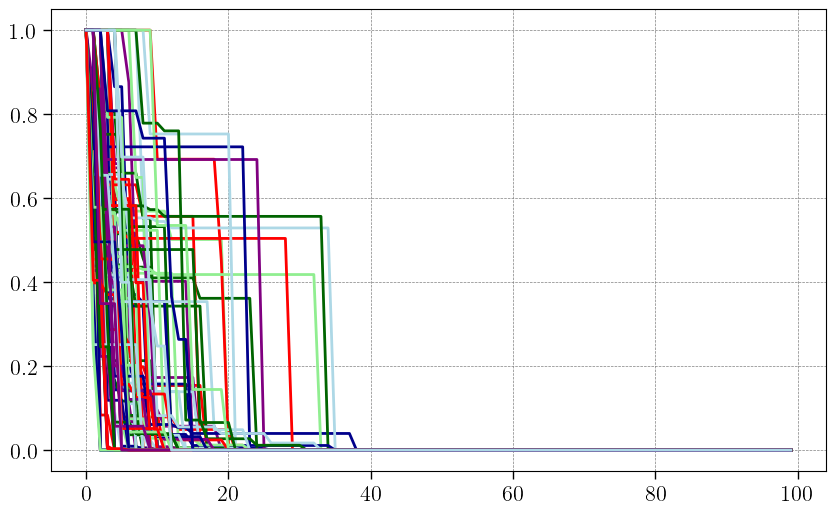

In [20]:
for i in range(0, 100):
    plt.plot(Ls_padded[i, :])

    for j in range(len(Ls_padded[i, :])):
        if Ls_padded[i, j]<0:
            print(i)
            print(Ls_padded[i, :])

In [21]:
Ls = np.mean(Ls_padded, axis = 0)

In [22]:
np.save(f'ops_{algorithm}', Ls)

In [23]:
Ls_AA = np.load('ops_AA.npy')
Ls_1wS = np.load('ops_1wS.npy')

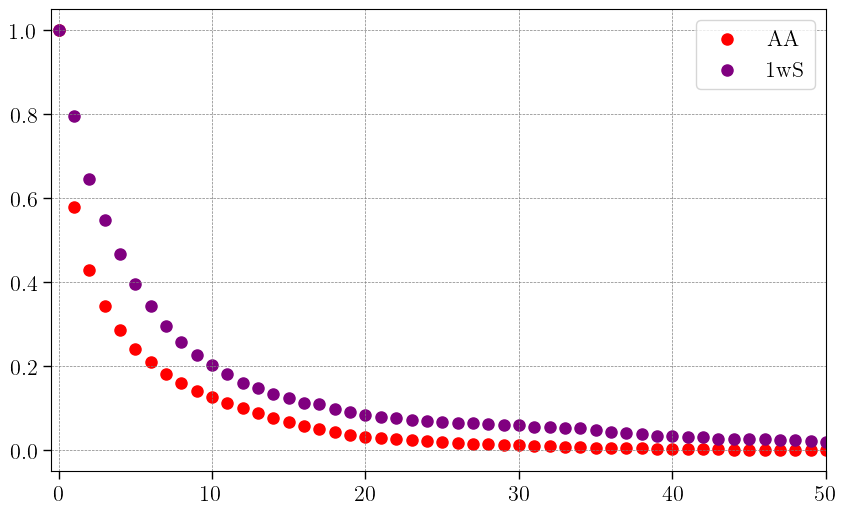

In [24]:
x = np.arange(len(Ls_AA))

plt.scatter(x, Ls_AA, label = 'AA')
plt.scatter(x, Ls_1wS, label = '1wS')

plt.xlim(-0.5,50)
#plt.ylim(0, 0.5)

plt.legend()

In [25]:
if AA == True:
    with open('data/LOPS_AA', 'wb') as f:
        pickle.dump(lengths_of_oldest_path, f)
    
    np.save('data/LOPS_padded_AA', Ls_padded)
   #np.save('data/ages_AA', ages_of_oldest_paths)
    
else:
    with open('data/LOPS_1w', 'wb') as f:
        pickle.dump(lengths_of_oldest_path, f)
    
    np.save('data/LOPS_padded_1w', Ls_padded)
    #np.save('data/ages_1w', ages_of_oldest_paths)